# Методы оптимизации
## Лабораторная работа № 3

In [23]:
import inspect
import numpy as np
import matplotlib.pyplot as plt
%pylab notebook

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [42]:
pylab.rcParams['figure.figsize'] = (20, 12)

In [43]:
def load_f(name):
    to = []
    with open(name,'r') as f:
        for line in f.readlines():
            if line.strip() == '':
                continue
            to.append(np.array([float(i) for i in line.strip().split(' ') if i != '']))
    return np.array(to)

In [44]:
P2 = load_f("P2.txt").T[2].reshape(1600,1)
P4_V1 = load_f("P4_V1.txt").T[2].reshape(1600,1)
P4_V2 = load_f("P4_V2.txt").T[2].reshape(1600,1)
P4_V3 = load_f("P4_V3.txt").T[2].reshape(1600,1)
P4_V4 = load_f("P4_V4.txt").T[2].reshape(1600,1)

In [45]:
P2.shape,P4_V1.shape,P4_V2.shape,P4_V3.shape,P4_V4.shape

((1600, 1), (1600, 1), (1600, 1), (1600, 1), (1600, 1))

In [46]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(p):
    sns.set_context("talk")
    sns.set_style('whitegrid')
    X, Y, Z = p.T[0].reshape(40,40),p.T[1].reshape(40,40),p.T[2].reshape(40,40) 
    ax = plt.axes(projection='3d')
    ax.scatter(X,Y,Z)
    ax.plot_surface(X,Y,Z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)

In [47]:
def plot_countor(p):
    sns.set_context("talk")
    sns.set_style('whitegrid')
    X, Y, Z = p.T[0].reshape(40,40),p.T[1].reshape(40,40),p.T[2].reshape(40,40)
   
    cp = plt.contour(X, Y, Z, 40,colors='black');
    
    plt.clabel(cp, inline=True, fontsize=16)
    plt.colorbar(cp)
    plt.xlabel('x')
    plt.ylabel('y')

In [48]:
P2 = load_f("P2.txt")
P4_V1 = load_f("P4_V1.txt")
P4_V2 = load_f("P4_V2.txt")
P4_V3 = load_f("P4_V3.txt")
P4_V4 = load_f("P4_V4.txt")

<IPython.core.display.Javascript object>


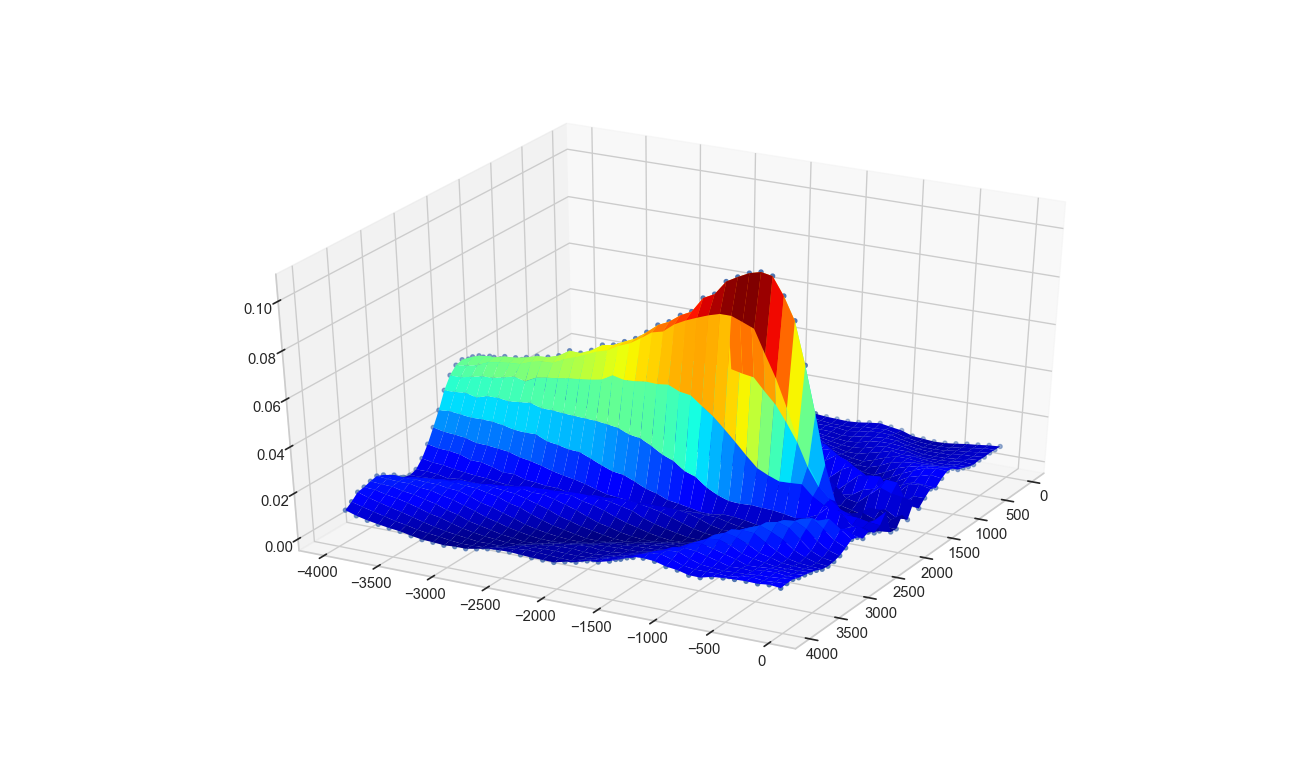

In [49]:
plot_3d(P2)


#### Метод перебора

In [470]:
def perebor(f):
    min = f[0][0]
    for i in range(len(f)):
        for j in range(len(f[0])):
            if (f[i][j]<min):
                min = f[i][j]
    print(min)
    
perebor(P2)

-3950.0


#### Метод поиска по шаблону

#### Метод случайного поиска

In [289]:
def random_search(f):
    n = int(f.shape[0]*0.5)
    best_f = f[0][0]
    for i in np.random.permutation(f.shape[0])[:n]:
        for j in np.random.permutation(f.shape[1])[:n]:
            if f[i][j] < best_f:
                best_f = f[i][j]
    return best_f

random_search(P2)

-3950.0

#### Метод имитации отжига

In [224]:
### Больцмановский отжиг
def T_b(k,T0=1e4):
    return T0/np.log(1+k)

def G_b(dx,T,D=2):
    a1 = 1/np.sqrt(2*np.pi*T)**D
    a2 = np.exp(-(dx**2)/(2*T))
    return a1*a2

def h(de,T):
    a = np.exp(-de/T)
    if a is None:
        return 0
    return a
    

In [225]:
### Отжиг Коши
def T_k(k,T0=100):
    return T0/k

def G_k(dx,T,D=2):
    a = T/(dx**2 + T**2)/np.pi
    return a**D
    

In [228]:
### Тушение больцмана
def T_bt(k,c=0.8,T0=1e4):
    return T0*c**k
    

In [547]:
def my_G(dx,a,b):
    return np.random.randint(0,a),np.random.randint(0,b)

In [548]:
def imitation_of_fire(f,a0,b0,T=T_bt,G=my_G,h=h):
    x,y = int(np.random.rand()*a0),int(np.random.rand()*b0)
    E_o = f(x,y)
    k = 0
    max_iter = 10000
    er = max_iter
    a = np.random.rand()
    x_n,y_n=0,0
    while True:
        k += 1
        #x_n,y_n = G(np.array([x,y]),T(k))
        x_n,y_n = G(np.array([x,y]),a0,b0)
        E_n = f(x_n,y_n)
        a = np.random.rand()
        if a < h(E_n-E_o,T(k)) and E_n < E_o:
            E_o = E_n
            x,y = x_n,y_n
            er = max_iter
        else:
            er -= 1
            k -= 1
            if er == 0:
                break
    return E_o

f = lambda x,y: P2[int(x)][int(y)]
imitation_of_fire(f,P2.shape[0],P2.shape[1])

0.00225006

#### Генетический алгоритм

In [552]:
def create_new_population(f,a,h=100):
    population = []
    #scores = []
    
    while not len(population) == h:
        new_child = []
        for ai in a:
            new_child.append(np.random.randint(ai))
        
        population.append(np.array(new_child))
        #scores.append(f(*new_child))
    
    #return np.array(population),np.array(np.array(scores))
    #return population,scores
    return population
    
def sort_pop(f,population):
    n = len(population)
    scores = np.zeros(n)
    for i in range(n):
        scores[i] = f(*population[i])
        
    arg_sort = scores.argsort()
    return np.array(population)[arg_sort].tolist()

def arg_sort_pop(f,population):
    n = len(population)
    scores = np.zeros(n)
    for i in range(n):
        scores[i] = f(*population[i])
        
    arg_sort = scores.argsort()
    return arg_sort

def create_new_generation(f,population,a,n_s=50,n_m=0.1,n_c=0.4):
    n = len(population)
    n_c = int(n_c*n)
    n_m = int(n_m*n)
    #n_s = int(n_s*n)
    
    p = np.random.permutation(n)
    for i in range(n_c):
        np.random.shuffle(p)
        p1 = population[p[0]]
        p2 = population[p[1]]
        population += crossingover(p1,p2)
        
    for i in range(n_m):
        mutant_index = p[i]
        population[mutant_index] = mutation(population[mutant_index],a)
    
    return sort_pop(f,population)[:n_s]

def create_new_generation2(f,population,a,n_s=50,n_m=0.2,n_c=0.4):
    n = len(population)
    n_c = int(n_c*n)
    n_m = int(n_m*n)
    #n_s = int(n_s*n)
    
    for i in arg_sort_pop(f,population)[-n_m:]:
        population[i] = mutation(population[i],a)
    
    p = np.random.permutation(n)
    
    for i in range(n_c):
        np.random.shuffle(p)
        p1 = population[p[0]]
        p2 = population[p[1]]
        population += crossingover(p1,p2)
    
    return sort_pop(f,population)[:n_s]
        
def crossingover(p1,p2):
    pop_cross = []
    for i in range(len(p1)):
        for j in range(len(p2)):
            if i != j:
                pn1 = copy(p1)
                pn2 = copy(p2)
                
                pn1[j] = p2[j]
                pn2[i] = p1[i]
                
                pop_cross.append(np.array(pn1))
                pop_cross.append(np.array(pn2))
                
    return pop_cross

def mutation(p,a):
    c = np.random.randint(len(a))
    a = a[c]
    p[c] = np.random.randint(a)
    return p

def genetic(f,a,count_gen=100,h=50):
    p1 = create_new_population(f,a,h=h)
    
    for i in range(count_gen):
        p1 = create_new_generation(f,p1,a)
    return f(*p1[0])

def genetic2(f,a,count_gen=100,h=50):
    p2 = create_new_population(f,a,h=h)

    for i in range(count_gen):
        p2 = create_new_generation2(f,p2,a)
        
    return f(*p2[0])

f = lambda x,y: P2[int(x)][int(y)]
genetic(f,[P2.shape[0],P2.shape[1]])

0.00263354

In [553]:
f = lambda x,y: P2[int(x)][int(y)]
a = [P2.shape[0],P2.shape[1]]
test_ans = -3950
err1 = 0
err2 = 0
for i in range(100):
    ans1 = genetic(f,a)-test_ans
    ans2 = genetic2(f,a)-test_ans
    if ans1 != 0:
        err1 +=1
    if ans2 != 0:
        err2 +=1
        
err1,err2

(100, 100)

In [554]:
def test(P):
    f = lambda x,y: P[int(x)][int(y)]
    a = [P.shape[0],P.shape[1]]
    return perebor(P),random_search(P),imitation_of_fire(f,a[0],a[1]),genetic(f,a),genetic2(f,a)

In [555]:
test(P4_V1),test(P4_V2),test(P4_V3),test(P4_V4)

0.00159419
0.00140179
0.000768731
0.00130828


((None, 0.00190255, 0.00159419, 0.00159419, 0.00159419),
 (None, 0.00140179, 0.00140179, 0.00181148, 0.00166633),
 (None, 0.00171128, 0.000768731, 0.00171128, 0.00167134),
 (None, 0.00198873, 0.00130828, 0.00202447, 0.00130828))

In [556]:
np.min(P4_V1),np.min(P4_V2),np.min(P4_V3),np.min(P4_V4)

(0.00159419, 0.00140179, 0.000768731, 0.00130828)